<a href="https://colab.research.google.com/github/kylemath/eeg-notebooks/blob/master/notebooks/Deep_eeg_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep-eeg-notebooks

Goal is to make a deep learning LSTM stack that processes Muse eeg-notebook EEG trials as input and predicts binary trial category as output.

Strategy:
* Load in Muse data, normal pre-processing to get to trials
* Decimate down to reduce features in time x frequency x electrode
* Avoid CNN?
* load time steps into LSTM?
* Predict attend left vs attend right on muse 375 data

API:
* Want to input the data directory of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks)
* More general with the master eeg-notebooks - https://github.com/NeuroTechX/eeg-notebooks


LearningModels:
* First try simple CNN
* then add in LSTM component to treat time as recurrent

DataModels:
* First pool data over subjects
* Try subject specific models
* Then try multilevel models

Using: 
* https://github.com/pbashivan/EEGLearn
* https://github.com/tevisgehr/EEG-Classification
* https://github.com/kylemath/eeg-notebooks
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/keras_classification.ipynb

Resources:
*   http://proceedings.mlr.press/v56/Thodoroff16.pdf
*   https://arxiv.org/abs/1511.06448




**Setup**

In [1]:
!git clone https://github.com/tevisgehr/EEG-Classification.git
%cd EEG-Classification
from eeg_learn_functions import *
%cd ..

!git clone https://github.com/kylemath/eeg-notebooks.git
%cd eeg-notebooks/notebooks
!pip install mne
from utils import utils

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt
np.random.seed(1017)

from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import seaborn as sns
import scipy.stats as scs
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split



Cloning into 'EEG-Classification'...
remote: Enumerating objects: 201, done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 201
Receiving objects: 100% (201/201), 16.68 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/EEG-Classification
/content
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1688 (delta 99), reused 143 (delta 43), pack-reused 1466
Receiving objects: 100% (1688/1688), 107.92 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (722/722), done.
Checking out files: 100% (484/484), done.
/content/eeg-notebooks/notebooks
    100% |████████████████████████████████| 6.2MB 7.3MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


**Parameters**

In [20]:
#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

#for testing
#subs = [ 205, 207, 208, 209]

#number of sessions in each subject folder
nsesh = 2

data_dir = 'visual/cueing'
event_ids = ['LeftCue','RightCue']


## Can load other experiments like this
#subs = [ 1]
#nsesh = 1
#data_dir = 'visual/SSVEP'
#event_ids = ['F1','F2']
##

load_verbose = 0 #print output during loading

frequency_domain = 1  #if True uses wavelets otherwise use time series

sfreq=256.

#filter
eeg_filter_highpass = 1
eeg_filter_lowpass = 30

#artifact rejection
rej_thresh_uV = 1000  #300 removes most blinks, 1000 keeps most trials
rej_thresh = rej_thresh_uV*1e-6

#trial epoch limits 
tmin=-1
tmax=2
decim=20  # to decrease number of time features
baseline=(-1, 0) #gets removed from training data but used during processing

#wavelet settings
f_low = 4
f_high = 20
f_bins = 10  # to decrease number of frequency features
frequencies =  np.linspace(4, 10, f_bins, endpoint=True)
wave_cycles = 6
spect_baseline = [-1,-.5] #gets removed from training data but used during processing
electrodes_out = [0,1,2,3]  # to decrease number of electrode features from [0,1,2,3] or [0,1,2,3,4] with aux electrode (untested)

#Training Settings
batch_size = 16
train_epochs = 100
num_classes = len(event_ids)

print('Parameters Set')

Parameters Set


**Preprocessing of EEG Data**

* LoadData - Each data file is from one session of one subject of the muse cueing task from eeg-notebooks from psych 375 A1 dataset
* Filtering - Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.
* Epoching - Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

In [21]:
#Load Data
print('Loading Data')
isub = subs[0]
print(isub)
raw = utils.load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  
#Filtering
print('Filtering Data')
raw.filter(eeg_filter_highpass,eeg_filter_lowpass, method='iir', verbose='WARNING' )

#Plot filtred data spectra if desired
#raw.plot_psd(fmin=eeg_filter_highpass, fmax=eeg_filter_lowpass ) 

#Epoching
event_id = {event_ids[0]: 1, event_ids[1]: 2}
events = find_events(raw)
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
%matplotlib inline
conditions = OrderedDict()
conditions[event_ids[0]] = [1]
conditions[event_ids[1]] = [2]

#plot ERPs if desired
#fig, ax = utils.plot_conditions(epochs, conditions=conditions, ylim=(-20,20) )

Loading Data
101
102
103
104
105
106
108
109
110
111
112
202
203
204
205
207
208
209
210
211
301
302
303
304
305
306
307
308
309
Filtering Data
4583 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  50.687322714379235


TODO: Time domain features:

** Spectrogram **

* All electrodes are considered on each trial
* Many frequencies are used in the wavelet analysis while the output of the morlet is decimated in time.
* Two conditions are done separate and concatenated
* X is a trials x freq x time matrix
* Y is a trials array of condition labels (turned into one hot vectors later in code)


Computing Morlet Wavelets on LeftCue
Applying baseline correction (mode: mean)
LeftCue Time Points: 26
LeftCue Frequencies: 10
Computing Morlet Wavelets on RightCue
Applying baseline correction (mode: mean)
RightCue Time Points: 26
RightCue Frequencies: 10
Combined X Shape: (2260, 10, 26, 4)
Combined Y Shape: (2260,)
Combined Y: [0. 0. 0. ... 1. 1. 1.]
X Range: -39.14267782990588:41.26281332404658
X Examples:


''

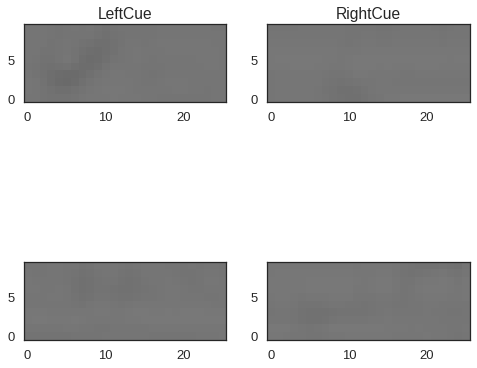

In [22]:
if frequency_domain:
  # Condition0
  print('Computing Morlet Wavelets on ' + event_ids[0])

  tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
  stim_onset = np.argmax(tfr0.times>0)
  new_times = tfr0.times[stim_onset:]
  cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3)
  #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image

  print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

  #Condition1
  print('Computing Morlet Wavelets on ' + event_ids[1])
  tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
  cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
  #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image

  print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))

  X = np.append(cond0_power_out,cond1_power_out,0);
  
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  #Append Data
  Y = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0);
  
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y.shape))
  print('Combined Y: ' + str(Y))
  print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
  print('X Examples:')

  #for plotting
  
  vmin = (np.std(X)/4) * -1
  vmax = np.std(X)/4  

  #Plot Example Data
  f, axarr = plt.subplots(2,2, figsize = (8,8))
  axarr[0][0].set_title(event_ids[0])
  axarr[0][0].imshow(X[0,:,:,1],vmin=vmin, vmax=vmax)

  axarr[0][0].invert_yaxis()
  axarr[1][0].imshow(X[1,:,:,1],vmin=vmin, vmax=vmax)
  axarr[1][0].invert_yaxis()

  axarr[0][1].set_title(event_ids[1])
  axarr[0][1].imshow(X[-1,:,:,1],vmin=vmin, vmax=vmax)
  axarr[0][1].invert_yaxis()
  axarr[1][1].imshow(X[-2,:,:,1],vmin=vmin, vmax=vmax)
  axarr[1][1].invert_yaxis()
;



**Time Domain**

* Instead may want to retain time domain data
* After Epoching, arange data into useful format with labels

In [0]:
if not frequency_domain:
  print(raw._data.shape)
  print(epochs._data.shape)
  print(conditions)

**Prepare Data for Model**


In [24]:
# convert class vectors to binary class matrices and recast X
Y = keras.utils.to_categorical(Y, num_classes)
X = X.astype('float32')

# Split training test and validation data 
test_split = 0.2
val_split = 0.2
random_seed = 1017

val_prop = val_split / (1-test_split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
input_shape = (X.shape[1], X.shape[2], len(electrodes_out))

print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')


Input Shape: (10, 26, 4)
x_train shape: (1356, 10, 26, 4)
1356 train samples
452 test samples
452 validation samples


**Build Model and Train**

Train on 1356 samples, validate on 452 samples
Epoch 1/100
1356/1356 [==============================] - 1s 505us/step - loss: 0.8118 - acc: 0.4985 - val_loss: 0.7511 - val_acc: 0.5066
Epoch 2/100
1356/1356 [==============================] - 0s 284us/step - loss: 0.7413 - acc: 0.5029 - val_loss: 0.7537 - val_acc: 0.4801
Epoch 3/100
1356/1356 [==============================] - 0s 291us/step - loss: 0.7229 - acc: 0.5059 - val_loss: 0.7179 - val_acc: 0.4425
Epoch 4/100
1356/1356 [==============================] - 0s 312us/step - loss: 0.7147 - acc: 0.5361 - val_loss: 0.7269 - val_acc: 0.4823
Epoch 5/100
1356/1356 [==============================] - 0s 338us/step - loss: 0.6842 - acc: 0.5531 - val_loss: 0.7169 - val_acc: 0.5066
Epoch 6/100
1356/1356 [==============================] - 0s 368us/step - loss: 0.6986 - acc: 0.5413 - val_loss: 0.7211 - val_acc: 0.5066
Epoch 7/100
1356/1356 [==============================] - 0s 347us/step - loss: 0.6853 - acc: 0.5472 - val_loss: 0.7307 - val_acc: 0

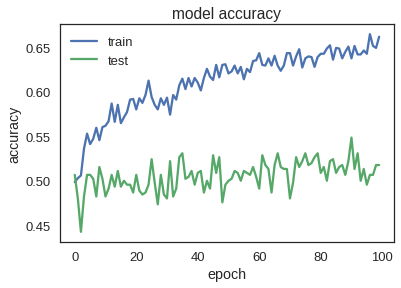

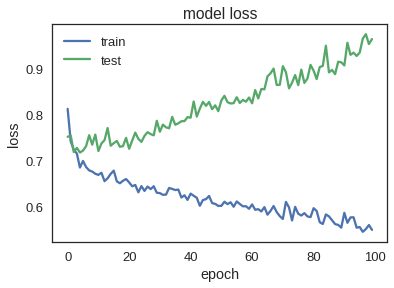

452/452 [==============================] - 0s 170us/step
Test score: 1.078889205392483
Test accuracy: 0.4823008849557522


In [25]:
#DenseFeedforward Network
model = Sequential()
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(.20))
model.add(Dense(2, activation='softmax'))


#model.add(Dropout(.10))

# Create CNN in keras
#model = Sequential()
#model.add(Conv2D(49, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(10))
#model.add(Activation('relu'))
#model.add(Dense(num_classes))
#model.add(Activation('softmax'))

# initiate adam optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



#Train Model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=train_epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          verbose=True)
         
#Summarize
model.summary()
 
  
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test on left out Test data
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)